In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import torch
torch.manual_seed(0)

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

/home/gridsan/mmurphy/.conda/envs/HumanProteinAtlas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Marker proteins of anatomical regions listed in "The kidney transcriptome and proteome defined by transcriptomics and antibody-based profiling".

In [5]:
hpa_markers = pd.read_csv('./data/hpa_markers.csv',comment='#')
gene_symbols = pd.read_table('./data/gene_symbols.tsv').iloc[:,[0,-1]]
hpa_markers = hpa_markers.merge(gene_symbols,
                                left_on='gene',right_on='Approved symbol',how='inner')
hpa_markers = hpa_markers.set_index(hpa_markers.columns[-1])[['region','gene']]
hpa_markers

,region,gene
Ensembl ID(supplied by Ensembl),,
ENSG00000128567,glomerulus,PODXL
ENSG00000158457,glomerulus,TSPAN33
ENSG00000113578,glomerulus,FGF1
ENSG00000116218,glomerulus,NPHS2
ENSG00000198743,glomerulus,SLC5A3
...,...,...
ENSG00000105707,collecting duct,HPN
ENSG00000214128,collecting duct,TMEM213
ENSG00000100362,collecting duct,PVALB


Our manual mapping of cell types in "Single cell transcriptional and chromatin accessibility profiling redefine cellular heterogeneity in the adult human kidney" to anatomical regions in "The kidney transcriptome and proteome defined by transcriptomics and antibody-based profiling".

In [4]:
hpa_mapping = pd.Series({
    'epithelial cell of proximal tubule':'proximal tubule',
    'fibroblast':None,
    'glomerular visceral epithelial cell':'glomerulus',
    'kidney capillary endothelial cell':'glomerulus',
    'kidney connecting tubule epithelial cell':'distal tubule',
    'kidney distal convoluted tubule epithelial cell':'distal tubule',
    'kidney loop of Henle thick ascending limb epithelial cell':'distal tubule',
    'leukocyte':None,
    'mesangial cell':'glomerulus',
    'parietal epithelial cell':'glomerulus',
    'renal alpha-intercalated cell':'collecting duct',
    'renal beta-intercalated cell':'collecting duct',
    'renal principal cell':'collecting duct'
},name='region')

Our method's per-image predictions. To permit evaluate we aggregate these first to antibody-level then to gene-level via averaging.

In [74]:
df = pd.read_csv('./data/hpa_v21_kidney.csv',index_col=0)

simclr_scores = pd.read_csv('./data/kidney_scores.csv',index_col=0)
simclr_scores = ( simclr_scores.join(df[['Antibody','Gene']])
                               .groupby(['Antibody','Gene']).mean()
                               .groupby('Gene').mean() )
simclr_scores

,epithelial cell of proximal tubule,fibroblast,glomerular visceral epithelial cell,kidney capillary endothelial cell,kidney connecting tubule epithelial cell,kidney distal convoluted tubule epithelial cell,kidney loop of Henle thick ascending limb epithelial cell,leukocyte,mesangial cell,parietal epithelial cell,renal alpha-intercalated cell,renal beta-intercalated cell,renal principal cell
Gene,,,,,,,,,,,,,
ENSG00000000003,0.077230,0.075579,0.072670,0.074995,0.077527,0.077423,0.085528,0.079077,0.072239,0.075080,0.080895,0.074670,0.077087
ENSG00000000005,0.075841,0.082139,0.078418,0.081860,0.072975,0.072073,0.078103,0.082416,0.078328,0.076883,0.075608,0.071697,0.073661
ENSG00000000419,0.076816,0.078123,0.078009,0.076817,0.076633,0.077222,0.080946,0.073379,0.074871,0.076543,0.078314,0.074793,0.077535
ENSG00000000457,0.071933,0.077451,0.080781,0.080453,0.073131,0.072888,0.079364,0.088554,0.077552,0.078802,0.075231,0.069816,0.074045
ENSG00000000460,0.080684,0.074107,0.074688,0.075457,0.075916,0.076970,0.077131,0.079923,0.078318,0.079573,0.075820,0.074521,0.076892
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288607,0.076812,0.074810,0.082577,0.075649,0.071027,0.073228,0.083852,0.087220,0.071780,0.081293,0.077627,0.069235,0.074891
ENSG00000288616,0.076812,0.074810,0.082577,0.075649,0.071027,0.073228,0.083852,0.087220,0.071780,0.081293,0.077627,0.069235,0.074891
ENSG00000288631,0.076812,0.074810,0.082577,0.075649,0.071027,0.073228,0.083852,0.087220,0.071780,0.081293,0.077627,0.069235,0.074891


Simple baseline: one-versus-rest Wilcoxon tests on scRNA.

# these are a little different! not sure why. think it's because I center cropped previously when evaluating embeddings. in principel this is better

In [132]:
adata = sc.read('./data/local.h5ad')
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.normalize_total(adata)
sc.tl.rank_genes_groups(adata,groupby='cell_type',method='wilcoxon',use_raw=False)

rna_scores = sc.get.rank_genes_groups_df(adata,group=None)
rna_scores = rna_scores.pivot(index='names',columns='group',values='scores')
rna_scores

Run "Comet": https://github.com/MSingerLab/COMETSC.

In [134]:
!mkdir -p ./scratch
adata[:,list(set(hpa_markers.index)&set(adata.var_names))].to_df().T.to_csv('./scratch/tabmarker.txt',sep='\t')
!touch tabvis.txt
adata.obs['cell_type'].reset_index().to_csv('./scratch/tabcluster.txt',sep='\t',index=False,header=False)

!conda create -y --name comet python==3.6 && source activate comet && python -m pip install COMETSC
!source activate comet && Comet ./scratch/tabmarker.txt ./scratch/tabvis.txt ./scratch/tabcluster.txt ./scratch/output/ -skipvis True -K 1 -C 32

Started on 2022-03-10T22:54:30.719546
Reading data...
Generating complement data...
['epithelial cell of proximal tubule' 'fibroblast'
 'glomerular visceral epithelial cell' 'kidney capillary endothelial cell'
 'kidney connecting tubule epithelial cell'
 'kidney distal convoluted tubule epithelial cell'
 'kidney loop of Henle thick ascending limb epithelial cell' 'leukocyte'
 'mesangial cell' 'parietal epithelial cell'
 'renal alpha-intercalated cell' 'renal beta-intercalated cell'
 'renal principal cell']
########
# Processing cluster epithelial cell of proximal tubule...
########
1 gene combinations
Running t test on singletons...
########
# Processing cluster fibroblast...
########
1 gene combinations
Running t test on singletons...
########
# Processing cluster glomerular visceral epithelial cell...
########
1 gene combinations
Running t test on singletons...
########
# Processing cluster kidney capillary endothelial cell...
########
1 gene combinations
Running t test on singletons

In [135]:
comet_scores = {}
fns = !ls ./output/data/cluster_*_positive_markers_ranked.csv
for fn in fns:
    cluster = fn.split('_')[1]
    comet_scores[cluster] = pd.read_csv(fn,index_col=0)['mHG_stat']
comet_scores = pd.DataFrame(comet_scores)
comet_scores

,epithelial cell of proximal tubule,fibroblast,glomerular visceral epithelial cell,kidney capillary endothelial cell,kidney connecting tubule epithelial cell,kidney distal convoluted tubule epithelial cell,kidney loop of Henle thick ascending limb epithelial cell,leukocyte,mesangial cell,parietal epithelial cell,renal alpha-intercalated cell,renal beta-intercalated cell,renal principal cell
ENSG00000004948,NaN,NaN,NaN,NaN,NaN,1.652947e-267,3.981895e-280,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000008196,NaN,NaN,NaN,NaN,NaN,8.708719e-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000010932,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000015413,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000016391,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000174827,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000176974,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000186335,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000186868,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Aggregate per-cell-type scores into per-region scores.

In [87]:
from src.classifier import platt_scaling

true_regions = hpa_markers.reset_index().pivot(index=hpa_markers.index.name,columns='region')['gene']
true_regions = true_regions.fillna(0).astype(bool).astype(int)

# only compare markers detected in all three
# in principle this shouldn't be an issue: RNA detects ~33k genes, and proteins measured in previous HPA should be present in v21 too
true_regions = true_regions.loc[set(true_regions.index)&set(simclr_scores.index)&set(rna_scores.index)]

def aggregate_regions(cell_type_scores, score_type):
    region_scores = cell_type_scores.T.join(hpa_mapping).groupby('region')
    if score_type=='probabilities':
        region_scores = region_scores.sum().T
    elif score_type=='test_statistics':
        region_scores = region_scores.max().T
    region_scores = region_scores.join(true_regions[[]],how='inner')
    region_scores.values[:] = region_scores.values / region_scores.sum(1).values[:,None]
    calibrated_scores = platt_scaling(region_scores, true_regions)
    return calibrated_scores

simclr_regions = aggregate_regions(simclr_scores,'probabilities')
rna_regions = aggregate_regions(rna_scores,'test_statistics')

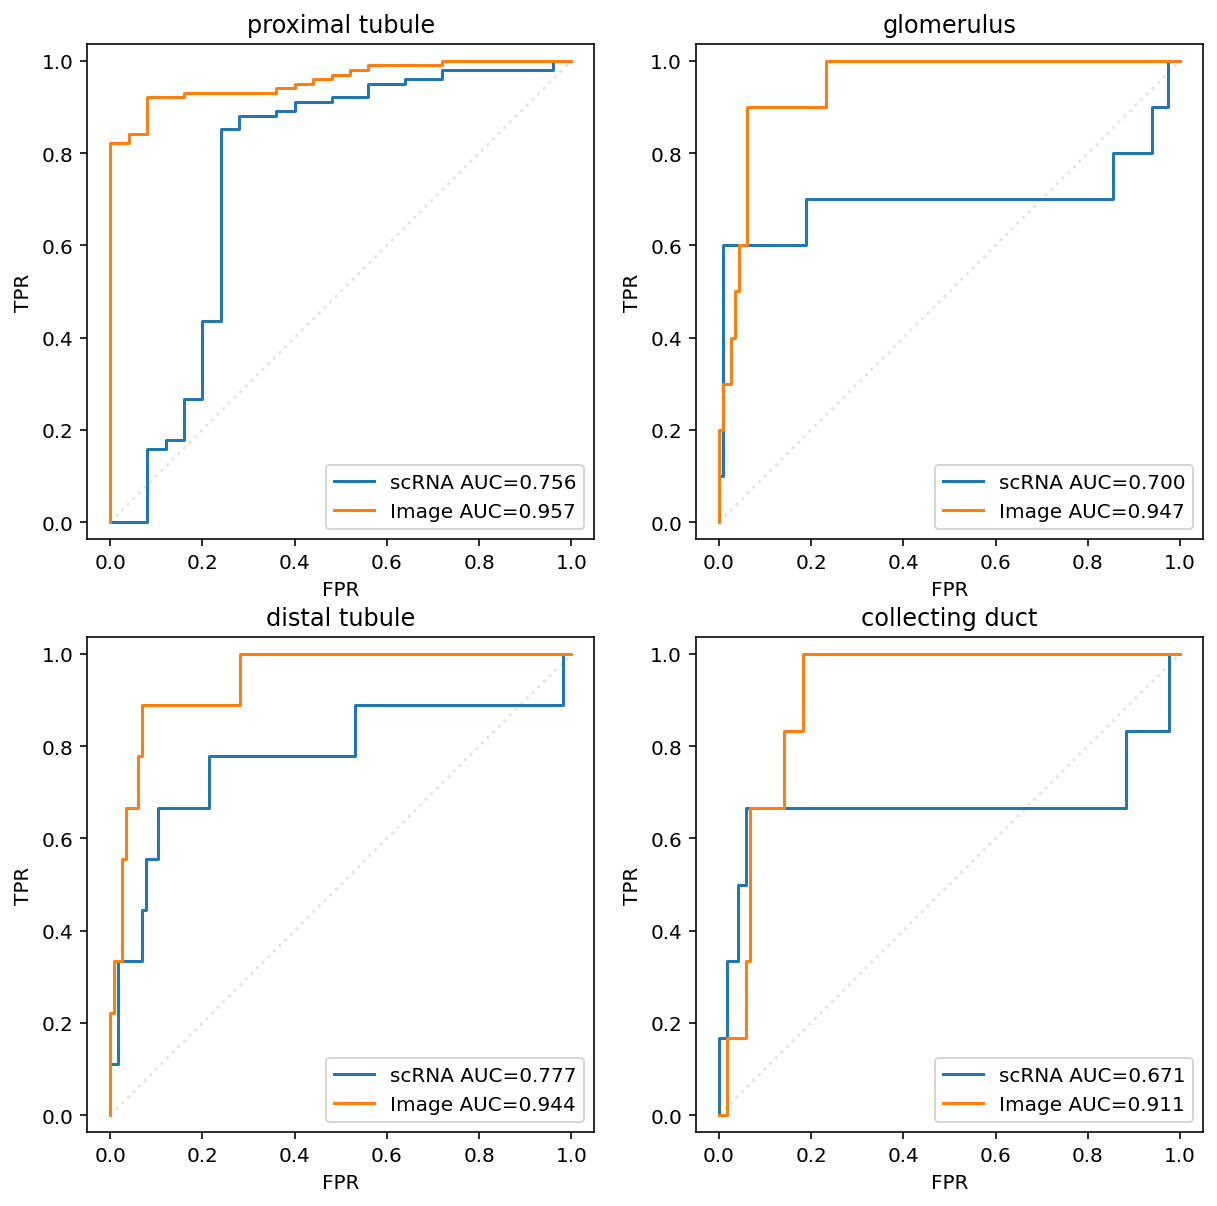

In [88]:
from sklearn.metrics import roc_curve, roc_auc_score

regions = true_regions.sum().sort_values(ascending=False).index.tolist()

figsize = 5
fig,axs = plt.subplots(2,len(regions)//2,figsize=(len(regions)//2*figsize,2*figsize))
axs=axs.ravel()
for ax,region in zip(axs,regions):
    ax.plot([0,1],[0,1],'k:',alpha=0.1)
    ax.set_title(region)

    name = 'scRNA'
    y = true_regions[region]
    y_pred = rna_regions[region]
    idx = list(set(y.index)&set(y_pred.index))
    y, y_pred = y[idx], y_pred[idx]
    fpr, tpr, thr = roc_curve(y,y_pred)
    auc = roc_auc_score(y,y_pred)
    ax.plot(fpr,tpr,label=f'{name} AUC=%.3f'%auc)
    
    name = 'Image'
    y = true_regions[region]
    y_pred = simclr_regions[region]
    idx = list(set(y.index)&set(y_pred.index))
    y, y_pred = y[idx], y_pred[idx]
    fpr, tpr, thr = roc_curve(y,y_pred)
    auc = roc_auc_score(y,y_pred)
    ax.plot(fpr,tpr,label=f'{name} AUC=%.3f'%auc)
    
    ax.axis('equal')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()